In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
from sphMath.kernels import getKernelEnum

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')
dtype = torch.float32

nx = 800
dim = 1
kernel = KernelType.B7
targetNeighbors = n_h_to_nH(4, 1)
CFL = 0.3

gamma = torch.tensor([5/3], dtype=dtype, device=device)
initialStateLeft = sodInitialState(1, 1, 0)
initialStateRight = sodInitialState(0.1795, 0.25, 0)
ratio = 1
smoothIC = False
timeLimit = 0.05

scheme = SimulationScheme.CompSPH
integrationScheme = IntegrationSchemeType.rungeKutta2
viscositySwitch = ViscositySwitch.NoneSwitch
supportScheme = AdaptiveSupportScheme.NoScheme

domain = buildDomainDescription(l = 2, dim = 1, periodic = True, device = device, dtype = dtype)

simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
     scheme, kernel, integrationScheme, 
     gamma, targetNeighbors, domain, 
     viscositySwitch=viscositySwitch, supportScheme = supportScheme)
particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
timesteps = int(timeLimit / dt)

True: dxs: [tensor(0.0012, device='cuda:0')], ns: [tensor(800, device='cuda:0', dtype=torch.int32)], nx: 800
True: dxs: [tensor(0.0012, device='cuda:0')], ns: [tensor(800, device='cuda:0', dtype=torch.int32)], nx: 800
Key adaptiveHThreshold not found in config["support"]. Setting adaptiveHThreshold to 0.001


In [4]:
timesteps = 100

In [5]:
# solverConfig['support']['scheme'] = None
# solverConfig['diffusionSwitch']['scheme'] = None

In [6]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None


for i in (tq:=tqdm(range(timesteps))):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    
    states.append(copy.deepcopy(simulationState))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item()
    })


  0%|          | 0/100 [00:00<?, ?it/s]

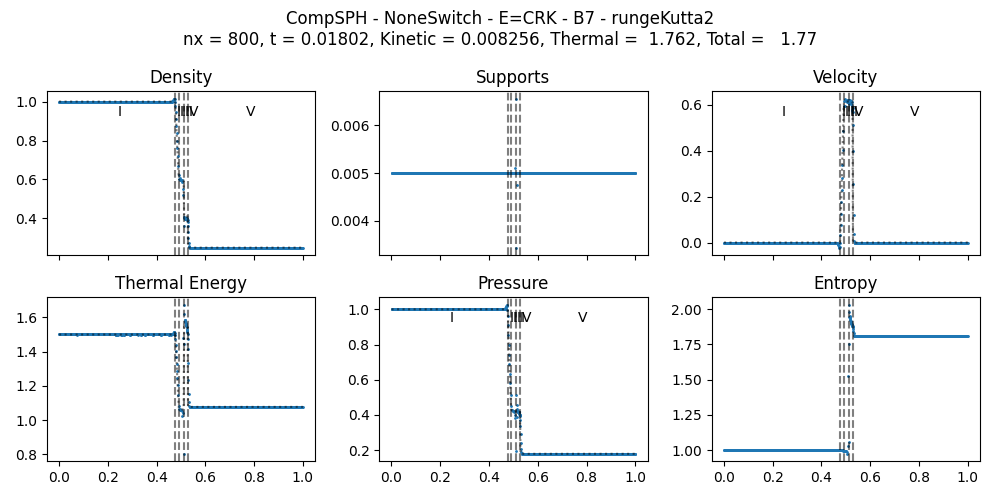

In [7]:
config2 = copy.deepcopy(solverConfig)
config2['fluid']['gamma'] = solverConfig['fluid']['gamma'].cpu()

plotSod(states[-1], config2, states[0].domain, gamma.cpu().item(), initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [8]:
referenceState = copy.deepcopy(states[-1])

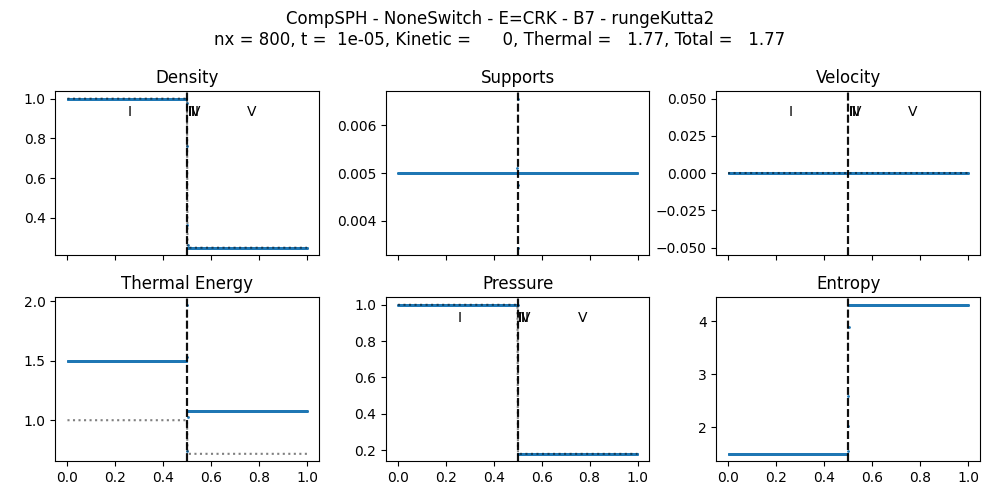

In [9]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

# masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.01 * simulationState.systemState.masses.max()

gamma = torch.tensor([2], dtype=dtype, device=device)
gamma.requires_grad_()
solverConfig['fluid']['gamma'] = gamma

# masses.requires_grad = True
# simulationState.systemState.masses = masses

with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma.detach().cpu().item(), initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [10]:


for i in (tq:=tqdm(range(timesteps))):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    
    with torch.no_grad():
        states.append(simulationState.nograd().to(device='cpu'))

    kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
    thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
    totalEnergy = kineticEnergy + thermalEnergy

    tq.set_postfix({
        'Kinetic Energy': kineticEnergy.item(),
        'Thermal Energy': thermalEnergy.item(),
        'Total Energy': totalEnergy.item(),
        'Time': simulationState.t.item()
    })


  0%|          | 0/100 [00:00<?, ?it/s]

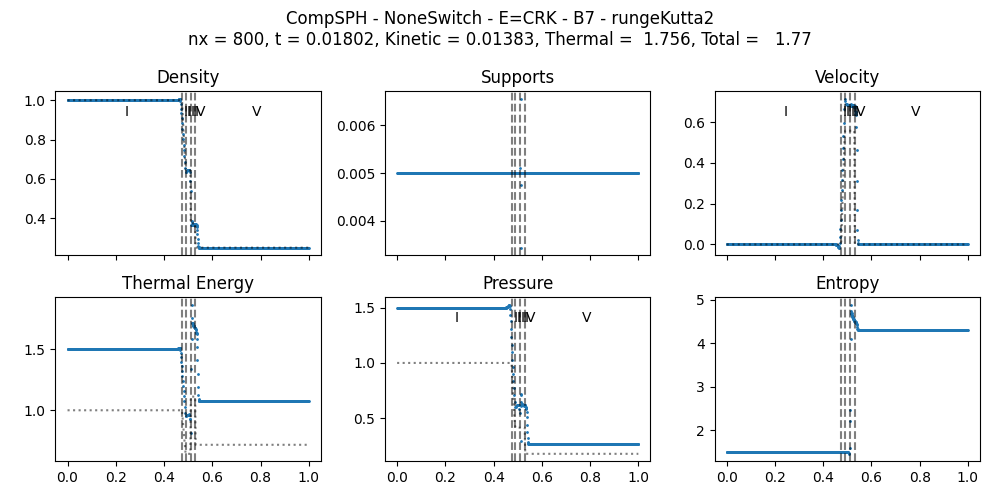

In [11]:

with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma.cpu().item(), initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [12]:
velocityLoss = torch.mean((simulationState.systemState.velocities - referenceState.systemState.velocities)**2)
velocityLoss.backward()

In [21]:
gamma.grad

tensor([0.0602], device='cuda:0')

In [24]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

# masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.01 * simulationState.systemState.masses.max()

# initialMasses = masses.clone()
# massIterations = []

# masses.requires_grad = True
# simulationState.systemState.masses = masses
gamma = torch.tensor([2], dtype=dtype, device=device)
gamma.requires_grad_()
gammaIterations = []

optimizer = torch.optim.Adam([gamma], lr = 1e-2)

for i in (tq:=tqdm(range(1024))):
    optimizer.zero_grad()
    solverConfig['fluid']['gamma'] = gamma
    simulationState = copy.deepcopy(particleSystem)
    simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
    # simulationState.systemState.masses = masses

    for i in (t:=tqdm(range(timesteps), leave=False)):
        simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
        simulationState.priorStep = [updates[-1], currentState[-1]]
        
    # rhoLoss = torch.mean((simulationState.systemState.densities - referenceState.systemState.densities)**2)
    # rhoLoss.backward()
    velocityLoss = torch.mean((simulationState.systemState.velocities - referenceState.systemState.velocities)**2)
    velocityLoss.backward()
    # positionLoss = torch.mean((simulationState.systemState.positions - referenceState.systemState.positions)**2)
    # positionLoss.backward()

    optimizer.step()

    tq.set_postfix({
        'Loss': velocityLoss.item(),
        'gamma': gamma.detach().cpu().item(),
        'gamma grad': gamma.grad.detach().cpu().item(),
    })
    # massIterations.append(masses.detach().cpu().numpy().copy())
    gammaIterations.append(gamma.detach().cpu().numpy().copy())
    

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
gammaIterations

[array([1.99], dtype=float32),
 array([1.9800036], dtype=float32),
 array([1.970013], dtype=float32),
 array([1.9600316], dtype=float32),
 array([1.9500617], dtype=float32),
 array([1.9401054], dtype=float32),
 array([1.9301664], dtype=float32),
 array([1.9202468], dtype=float32),
 array([1.9103506], dtype=float32),
 array([1.9004812], dtype=float32),
 array([1.8906423], dtype=float32),
 array([1.8808374], dtype=float32),
 array([1.8710707], dtype=float32),
 array([1.8613483], dtype=float32),
 array([1.8516749], dtype=float32),
 array([1.8420565], dtype=float32),
 array([1.8325], dtype=float32),
 array([1.8230143], dtype=float32),
 array([1.8136083], dtype=float32),
 array([1.8042915], dtype=float32),
 array([1.7950761], dtype=float32),
 array([1.785975], dtype=float32),
 array([1.7770009], dtype=float32),
 array([1.7681705], dtype=float32),
 array([1.7594992], dtype=float32),
 array([1.7510055], dtype=float32),
 array([1.7427073], dtype=float32),
 array([1.7346258], dtype=float32),
 a

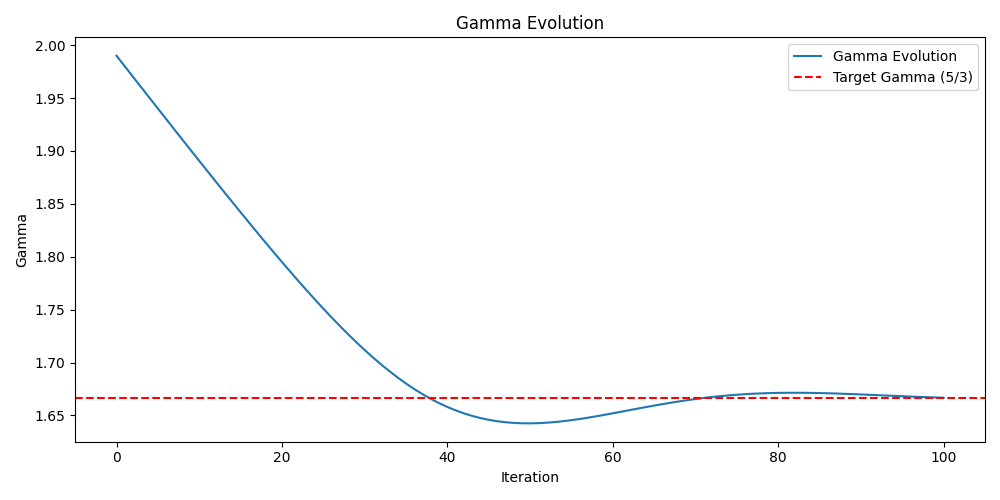

In [26]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5))
axis.plot(gammaIterations, label ='Gamma Evolution')
axis.set_xlabel('Iteration')
axis.set_ylabel('Gamma')
axis.set_title('Gamma Evolution')
axis.axhline(5/3, color='red', linestyle='--', label='Target Gamma (5/3)')
axis.legend()
# plt.show()
fig.tight_layout()

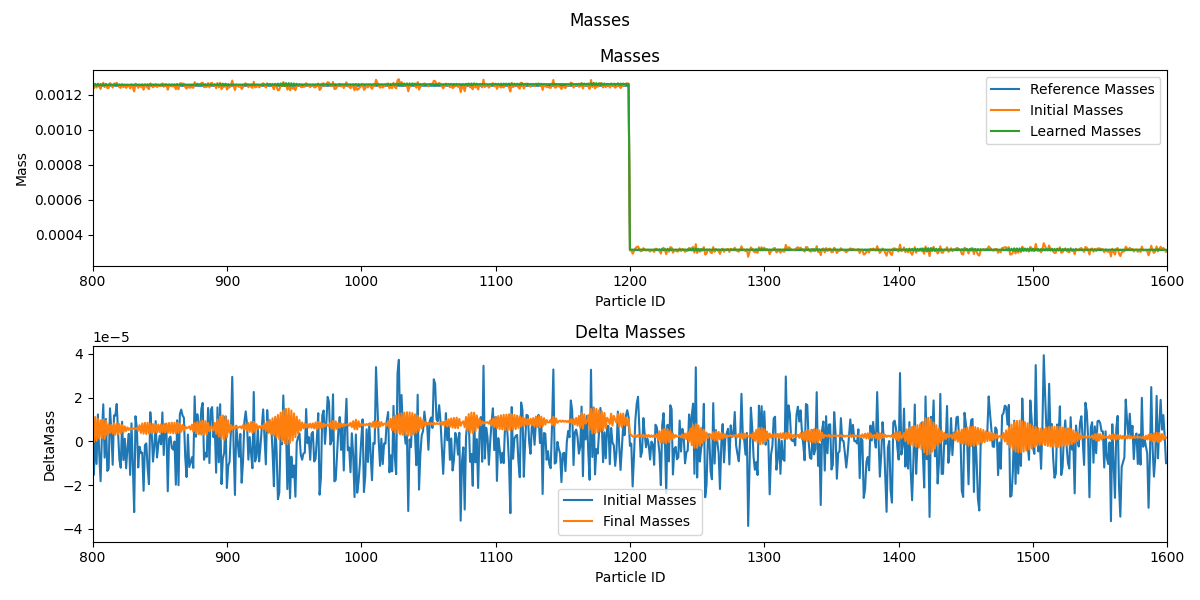

In [63]:
fig, axis = plt.subplots(2, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].set_xlim(nx,2*nx)
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].set_xlim(nx,2*nx)
axis[1,0].legend()

fig.tight_layout()

In [ ]:
simulationState = copy.deepcopy(particleSystem)
# simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
# simulationState.systemState.masses = masses

for i in (t:=tqdm(range(862), leave=False)):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    

  0%|          | 0/862 [00:00<?, ?it/s]

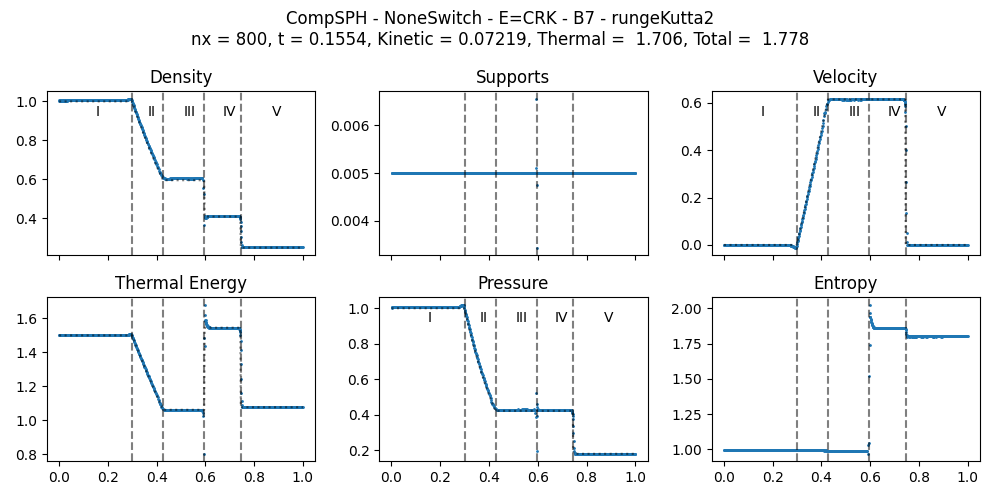

: 

In [ ]:
with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

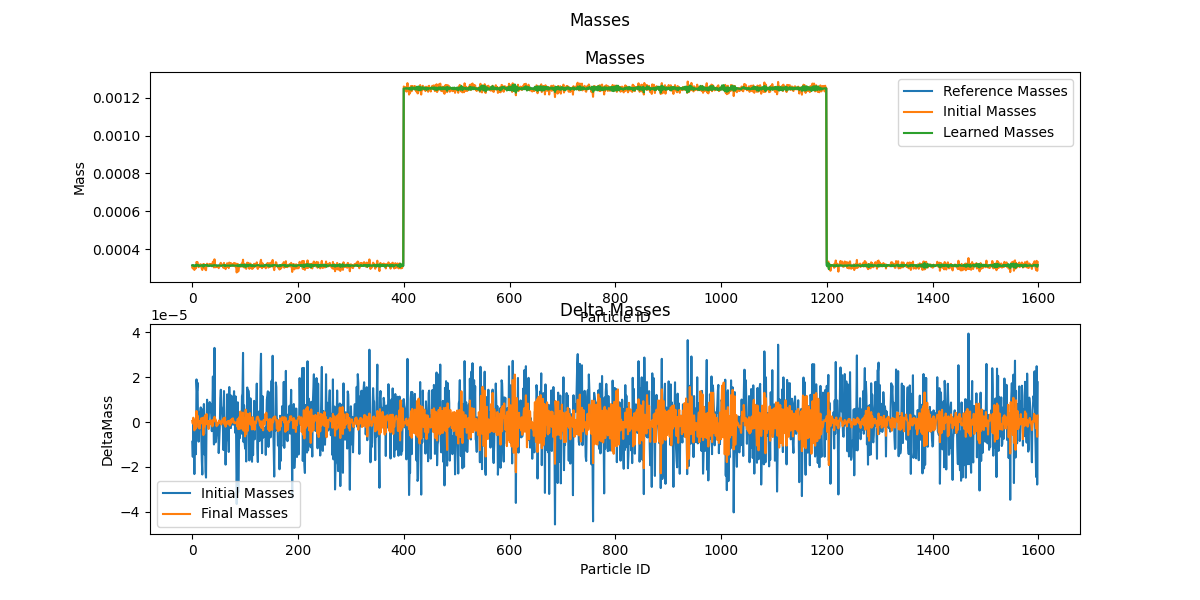

In [38]:
fig, axis = plt.subplots(2, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].legend()
